# Integration - building atlas

#### Integration process was demonstrated using Seurat objects asscoiated with this study, which are available on GEO under record GSE152766. 

#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    Protoplasting_DEgene_FC2_list.txt (from Denyer, et al. 2019)
    color_scheme_at.RData (required if one choose to perform correlation-based annotation)
    Root_bulk_arabidopsis_curated.RD (required if one choose to perform correlation-based annotation)
    
#### Note we put all the Seurat objects of sample under subdirectory COPILOT_RDS/

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
# Load libraries
suppressMessages(library(Matrix))
suppressMessages(library(ggplot2))
suppressMessages(library(scales))
suppressMessages(library(Seurat))
suppressMessages(library(plotly))
suppressMessages(library(grid))
suppressMessages(library(tidyverse))

In [3]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu314/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] forcats_0.5.0   stringr_1.4.0   dplyr_1.0.0     purrr_0.3.4    
 [5] readr_1.3.1     tidyr_1.1.0     tibble_3.0.1    tidyverse_1.3.0
 [9] plotly_4.9.2.1  Seurat_3.1.5    scales_1.1.1    ggplot2_3.3.1  
[13] Matrix_1.2-18  

loaded via a namespace (and not attached):
 [1] nl

## 1. Preparation

In [4]:
# Load unwanted genes, which are genes being induced during protoplasting in our case
pp.genes <- as.character(read.table("./supp_data/Protoplasting_DEgene_FC2_list.txt", header=F)$V1)

# Load the color scheme for time and cell type annotation
load("./supp_data/color_scheme_at.RData")

In [5]:
# Prepare a list of sample names that is going to be used for integration
use.sample <- c("sc_12","sc_11","sc_30","sc_31","sc_37","sc_40","sc_51","sc_9_at","sc_10_at","sc_1","tnw1","tnw2","col0","pp1","dc1","dc2")

In [6]:
# Read in Seurat objects and make a list out of them, here we put all the Seurat objects under the foler ./COPILOT_RDS 

read_seu <- function(dir,sample.name) { 
  seu <- readRDS(dir) 
  # remove unused data to save some memory (optional)
  seu@assays$spliced_RNA <- NULL
  seu@assays$spliced_SCT <- NULL
  seu@assays$unspliced_RNA <- NULL
  seu@assays$unspliced_SCT <- NULL
  return(seu)
}

list.filenames <- list.files(path = "./COPILOT_RDS/",pattern=".rds$") %>% .[match(use.sample, gsub("_COPILOT.rds","",.))]

rc.list <- list()

for (i in 1:length(list.filenames))
{
  rc.list[[i]]<-read_seu(dir = paste0("./COPILOT_RDS/",list.filenames[i]), sample.name = use.sample[i])
}

names(rc.list) <- list.filenames %>% gsub("_COPILOT.rds","",.)


## 2. Integration

In [50]:
# Select genes shared among samples that will be used for integration, for Arabidopsis, 25000 genes is about the upper limit of genes a single cell can have
rc.features <- SelectIntegrationFeatures(object.list = rc.list, nfeatures = 25000)
length(rc.features)

[1] 19984

In [51]:
# Remove mitochondrial, chloroplast and protoplasting-induced genes from the shared gene list
rc.features <- rc.features[-c(grep("ATMG",rc.features),grep("ATCG",rc.features),sort(match(pp.genes, rc.features)))]
length(rc.features)

[1] 17513

In [52]:
# Prepare for integration
rc.list <- PrepSCTIntegration(object.list = rc.list, anchor.features = rc.features, verbose = TRUE)

In [53]:
# Find integration anchors. Here we use sc_12, the sample with best quality, as reference, which is the first object in the Seuart object list
rc.anchors <- suppressMessages(FindIntegrationAnchors(object.list = rc.list, normalization.method = "SCT", 
    anchor.features = rc.features, verbose = TRUE, reference=1))

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [54]:
# Running integration
rc.integrated <- suppressMessages(IntegrateData(anchorset = rc.anchors, normalization.method = "SCT", verbose = TRUE))

Warning message:
“Adding a command log without an assay associated with it”


## 3. Run PCA, UMAP, Clustering

In [55]:
# Run PCA
rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)

In [70]:
# Find nearest neighbors
rc.integrated <- FindNeighbors(rc.integrated, reduction = "pca",dims = 1:50)

# Clustering, notice that here we choose SLM algorithm with resoltion 5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
rc.integrated <- FindClusters(rc.integrated, resolution = 5, algorithm = 3)

# Run 50D UMAP
rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 50)
rc.integrated@reductions$umap_50 <- rc.integrated@reductions$umap

# Run 3D UMAP
rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 3)
rc.integrated@reductions$umap_3D <- rc.integrated@reductions$umap

# Run 2D UMAP
rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
rc.integrated@reductions$umap_2D <- rc.integrated@reductions$umap

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 110427
Number of edges: 3393008

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8847
Number of communities: 116
Elapsed time: 138 seconds


## 4. Pseudo-bulk annotation (optional; highly dependent on parameters used for clustering )

In [71]:
# Extract integrated (batch-corrected and scaled) expression matrix
afm <- as.matrix(rc.integrated@assays$integrated@data)

# Pool (average) expression values of each cluster
pooled <- matrix(nrow=nrow(afm), ncol = 0)
for (i in 0:(length(unique(rc.integrated@meta.data$seurat_clusters))-1)) {
m <- afm[,which(rc.integrated@meta.data$seurat_clusters==i)]
pooled <- cbind(pooled, rowSums(m)/ncol(m))
}

In [72]:
# Load reference expression profiles
load(file="./supp_data/Root_bulk_arabidopsis_curated.RD")

# Annation (see notebook "1-Correlation-Based-Annotation.ipynb")
merge.rownames <- function (x,y){
  dat <- merge(x = x, y = y, by = "row.names")
  rownames(dat) <- dat$Row.names
  dat <- dat[,-1]
  return(dat)
}

time <- Reduce(merge.rownames, list(time,pooled))
celltype <- Reduce(merge.rownames, list(celltype,pooled)) 

time_label=c("Elongation", "Maturation", "Meristem")
celltype_label=c("phloem & companion cells", "developing cortex", "hair cells", "matured cortex",
                 "matured endodermis", "non-hair cells", "columella", "phloem pole pericycle", 
                 "matured xylem pole", "protophloem & metaphloem","developing xylem", "endodermis & QC cells", "LRC & non-hair cells","QC cells")

time_cor <- sapply(4:ncol(time), function(i) sapply(1:3, function(j) cor(time[,i],time[,j],method = "spearman")))
rownames(time_cor) <- time_label
time_max <- sapply(1:(ncol(time)-3), function(i) max(time_cor[,i]))
time_ident <- sapply(1:(ncol(time)-3), function(i) time_label[which(time_cor[,i]==max(time_cor[,i]))])
names(time_max) <- time_ident

celltype_cor <- sapply(15:ncol(celltype), function(i) sapply(1:14, function(j) cor(celltype[,i],celltype[,j],method = "spearman")))
rownames(celltype_cor) <- celltype_label
celltype_max <- sapply(1:(ncol(celltype)-14), function(i) max(celltype_cor[,i]))
celltype_ident <- sapply(1:(ncol(celltype)-14), function(i) celltype_label[which(celltype_cor[,i]==max(celltype_cor[,i]))])

names(celltype_max) <- celltype_ident

seucluster.celltype.ID <- celltype_ident
seucluster.timezone.ID <- time_ident
seucluster.celltype.cor <- celltype_max
seucluster.timezone.cor <- time_max

time_cor <- sapply(4:ncol(time), function(i) sapply(1:3, function(j) cor(time[,i],time[,j],method = "pearson")))
rownames(time_cor) <- time_label
time_max <- sapply(1:(ncol(time)-3), function(i) max(time_cor[,i]))
time_ident <- sapply(1:(ncol(time)-3), function(i) time_label[which(time_cor[,i]==max(time_cor[,i]))])
names(time_max) <- time_ident

celltype_cor <- sapply(15:ncol(celltype), function(i) sapply(1:14, function(j) cor(celltype[,i],celltype[,j],method = "pearson")))
rownames(celltype_cor) <- celltype_label
celltype_max <- sapply(1:(ncol(celltype)-14), function(i) max(celltype_cor[,i]))
celltype_ident <- sapply(1:(ncol(celltype)-14), function(i) celltype_label[which(celltype_cor[,i]==max(celltype_cor[,i]))])

names(celltype_max) <- celltype_ident

seucluster.celltype.ID.P <- celltype_ident
seucluster.timezone.ID.P <- time_ident
seucluster.celltype.cor.P <- celltype_max
seucluster.timezone.cor.P <- time_max   
            
time <- Reduce(merge.rownames, list(Long,pooled))
celltype <- Reduce(merge.rownames, list(Rad,pooled)) 
                         
time_label=c("Columella", "Meri-1", "Meri-2", "Meri-3", "Meri-4", "Meri-5", "Meri-6", "Elong-7", "Elong-8", "Mat-9", "Mat-10", "Mat-11", "Mat-12")
celltype_label=c("QC", "Hair Cell", "Cortex", "Non-Hair Cell", "Xylem Pole Pericycle", "LRC", 
             "Columella", "Phloem Pole Pericycle", "Mat.Xylem", "Meri.Xylem", "Phloem [S32]", "Endodermis", "Phloem [SUC2]")

time_cor <- sapply(14:ncol(time), function(i) sapply(1:13, function(j) cor(time[,i],time[,j],method = "spearman")))
rownames(time_cor) <- time_label
time_max <- sapply(1:(ncol(time)-13), function(i) max(time_cor[,i]))
time_ident <- sapply(1:(ncol(time)-13), function(i) time_label[which(time_cor[,i]==max(time_cor[,i]))])
names(time_max) <- time_ident

celltype_cor <- sapply(14:ncol(celltype), function(i) sapply(1:13, function(j) cor(celltype[,i],celltype[,j],method = "spearman")))
rownames(celltype_cor) <- celltype_label
celltype_max <- sapply(1:(ncol(celltype)-13), function(i) max(celltype_cor[,i]))
celltype_ident <- sapply(1:(ncol(celltype)-13), function(i) celltype_label[which(celltype_cor[,i]==max(celltype_cor[,i]))])

names(celltype_max) <- celltype_ident

seucluster.Rad.ID <- celltype_ident
seucluster.Long.ID <- time_ident
seucluster.Rad.cor <- celltype_max
seucluster.Long.cor <- time_max
                         
time_cor <- sapply(14:ncol(time), function(i) sapply(1:13, function(j) cor(time[,i],time[,j],method = "pearson")))
rownames(time_cor) <- time_label
time_max <- sapply(1:(ncol(time)-13), function(i) max(time_cor[,i]))
time_ident <- sapply(1:(ncol(time)-13), function(i) time_label[which(time_cor[,i]==max(time_cor[,i]))])
names(time_max) <- time_ident

celltype_cor <- sapply(14:ncol(celltype), function(i) sapply(1:13, function(j) cor(celltype[,i],celltype[,j],method = "pearson")))
rownames(celltype_cor) <- celltype_label
celltype_max <- sapply(1:(ncol(celltype)-13), function(i) max(celltype_cor[,i]))
celltype_ident <- sapply(1:(ncol(celltype)-13), function(i) celltype_label[which(celltype_cor[,i]==max(celltype_cor[,i]))])

names(celltype_max) <- celltype_ident

seucluster.Rad.ID.P <- celltype_ident
seucluster.Long.ID.P <- time_ident
seucluster.Rad.cor.P <- celltype_max
seucluster.Long.cor.P <- time_max
  
#store values
rc.ori.ident <- rc.integrated@active.ident

rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.celltype.cor
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.celltype.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.celltype.ID
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.celltype.ID <- as.character(rc.integrated@active.ident)
                         
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.celltype.cor.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.celltype.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.celltype.ID.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.celltype.ID.P <- as.character(rc.integrated@active.ident)

rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.timezone.cor
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.timezone.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.timezone.ID
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.timezone.ID <- as.character(rc.integrated@active.ident)
                         
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.timezone.cor.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.timezone.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.timezone.ID.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.timezone.ID.P <- as.character(rc.integrated@active.ident)

rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Rad.cor
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Rad.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Rad.ID
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Rad.ID <- as.character(rc.integrated@active.ident)
                         
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Rad.cor.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Rad.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Rad.ID.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Rad.ID.P <- as.character(rc.integrated@active.ident)
                         
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Long.cor
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Long.cor <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Long.ID
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Long.ID <- as.character(rc.integrated@active.ident)
                         
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Long.cor.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Long.cor.P <- as.numeric(levels(rc.integrated@active.ident)[rc.integrated@active.ident])
rc.integrated@active.ident <- rc.ori.ident
new.cluster.ids <- seucluster.Long.ID.P
names(new.cluster.ids) <- levels(rc.integrated)
rc.integrated <- RenameIdents(object = rc.integrated, new.cluster.ids)
rc.integrated@meta.data$seucluster.Long.ID.P <- as.character(rc.integrated@active.ident)

In [59]:
# Merge DoubletFinder results (optional) 
DF <- c()
for (i in grep("DF.classifications",colnames(rc.integrated@meta.data))){
    DF <- c(DF, rc.integrated@meta.data[,i][!is.na(rc.integrated@meta.data[,i])])
}
rc.integrated@meta.data$DF.classifications <- DF

## 5. Plotting

In [26]:
# Codes for rotating/fliping UMAP dimension (optional)
rc.integrated[["umap"]]@cell.embeddings[,1] <- rc.integrated[["umap"]]@cell.embeddings[,1]*-1
u2 <- rc.integrated@reductions$umap@cell.embeddings[,1]
u1 <- rc.integrated@reductions$umap@cell.embeddings[,2]
rc.integrated@reductions$umap@cell.embeddings[,1] <- u1
rc.integrated@reductions$umap@cell.embeddings[,2] <- u2

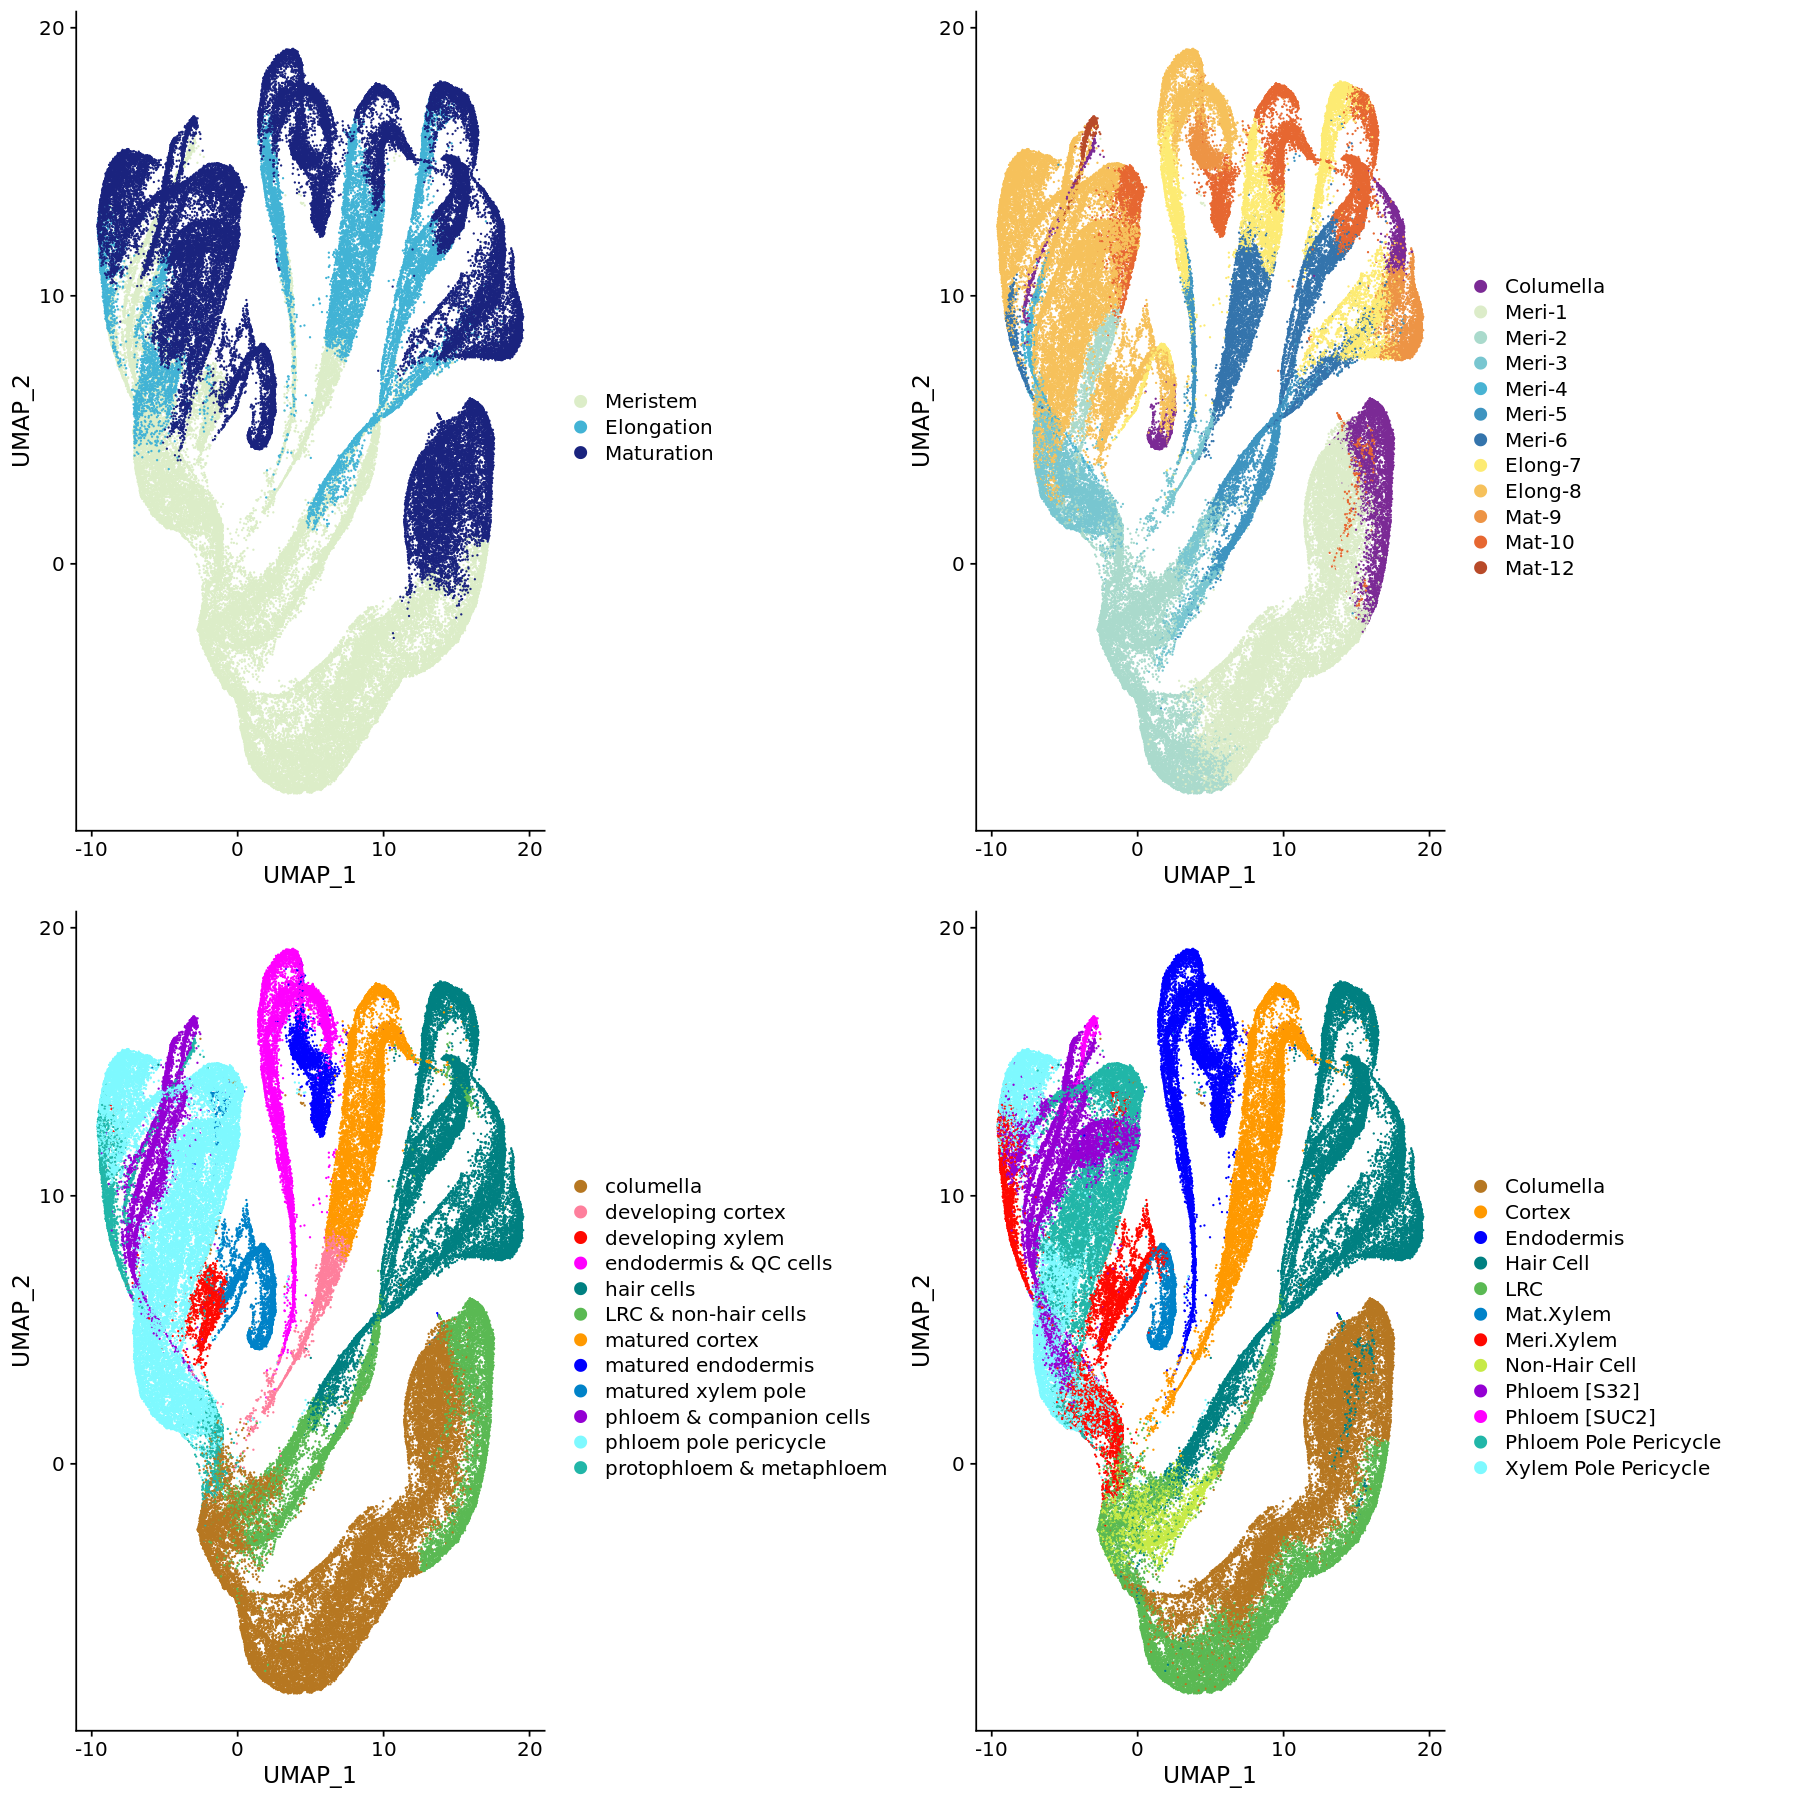

In [80]:
# Cluster-level correlation-based annotation (pseudo-bulk annotation)
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "seucluster.timezone.ID.P", order = c("Maturation","Elongation","Meristem"),cols = c("#DCEDC8", "#42B3D5", "#1A237E"))
rc.integrated@meta.data$seucluster.Long.ID.P <- factor(rc.integrated@meta.data$seucluster.Long.ID.P, levels = longorder[sort(match(unique(rc.integrated$seucluster.Long.ID.P),longorder))])  
color.long <- longpalette[sort(match(unique(rc.integrated$seucluster.Long.ID.P),longorder))]
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "seucluster.Long.ID.P", cols=color.long)
color <- celltypepalette[sort(match(unique(rc.integrated$seucluster.celltype.ID.P),celltypeorder))]
p3 <- DimPlot(rc.integrated, reduction = "umap", group.by = "seucluster.celltype.ID.P", cols = color)
color.rad <- radpalette[sort(match(unique(rc.integrated$seucluster.Rad.ID.P),radorder))]
p4 <- DimPlot(rc.integrated, reduction = "umap", group.by = "seucluster.Rad.ID.P", cols = color.rad)
options(repr.plot.width=15, repr.plot.height=15)
gl <- lapply(list(p1, p2, p3, p4), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)

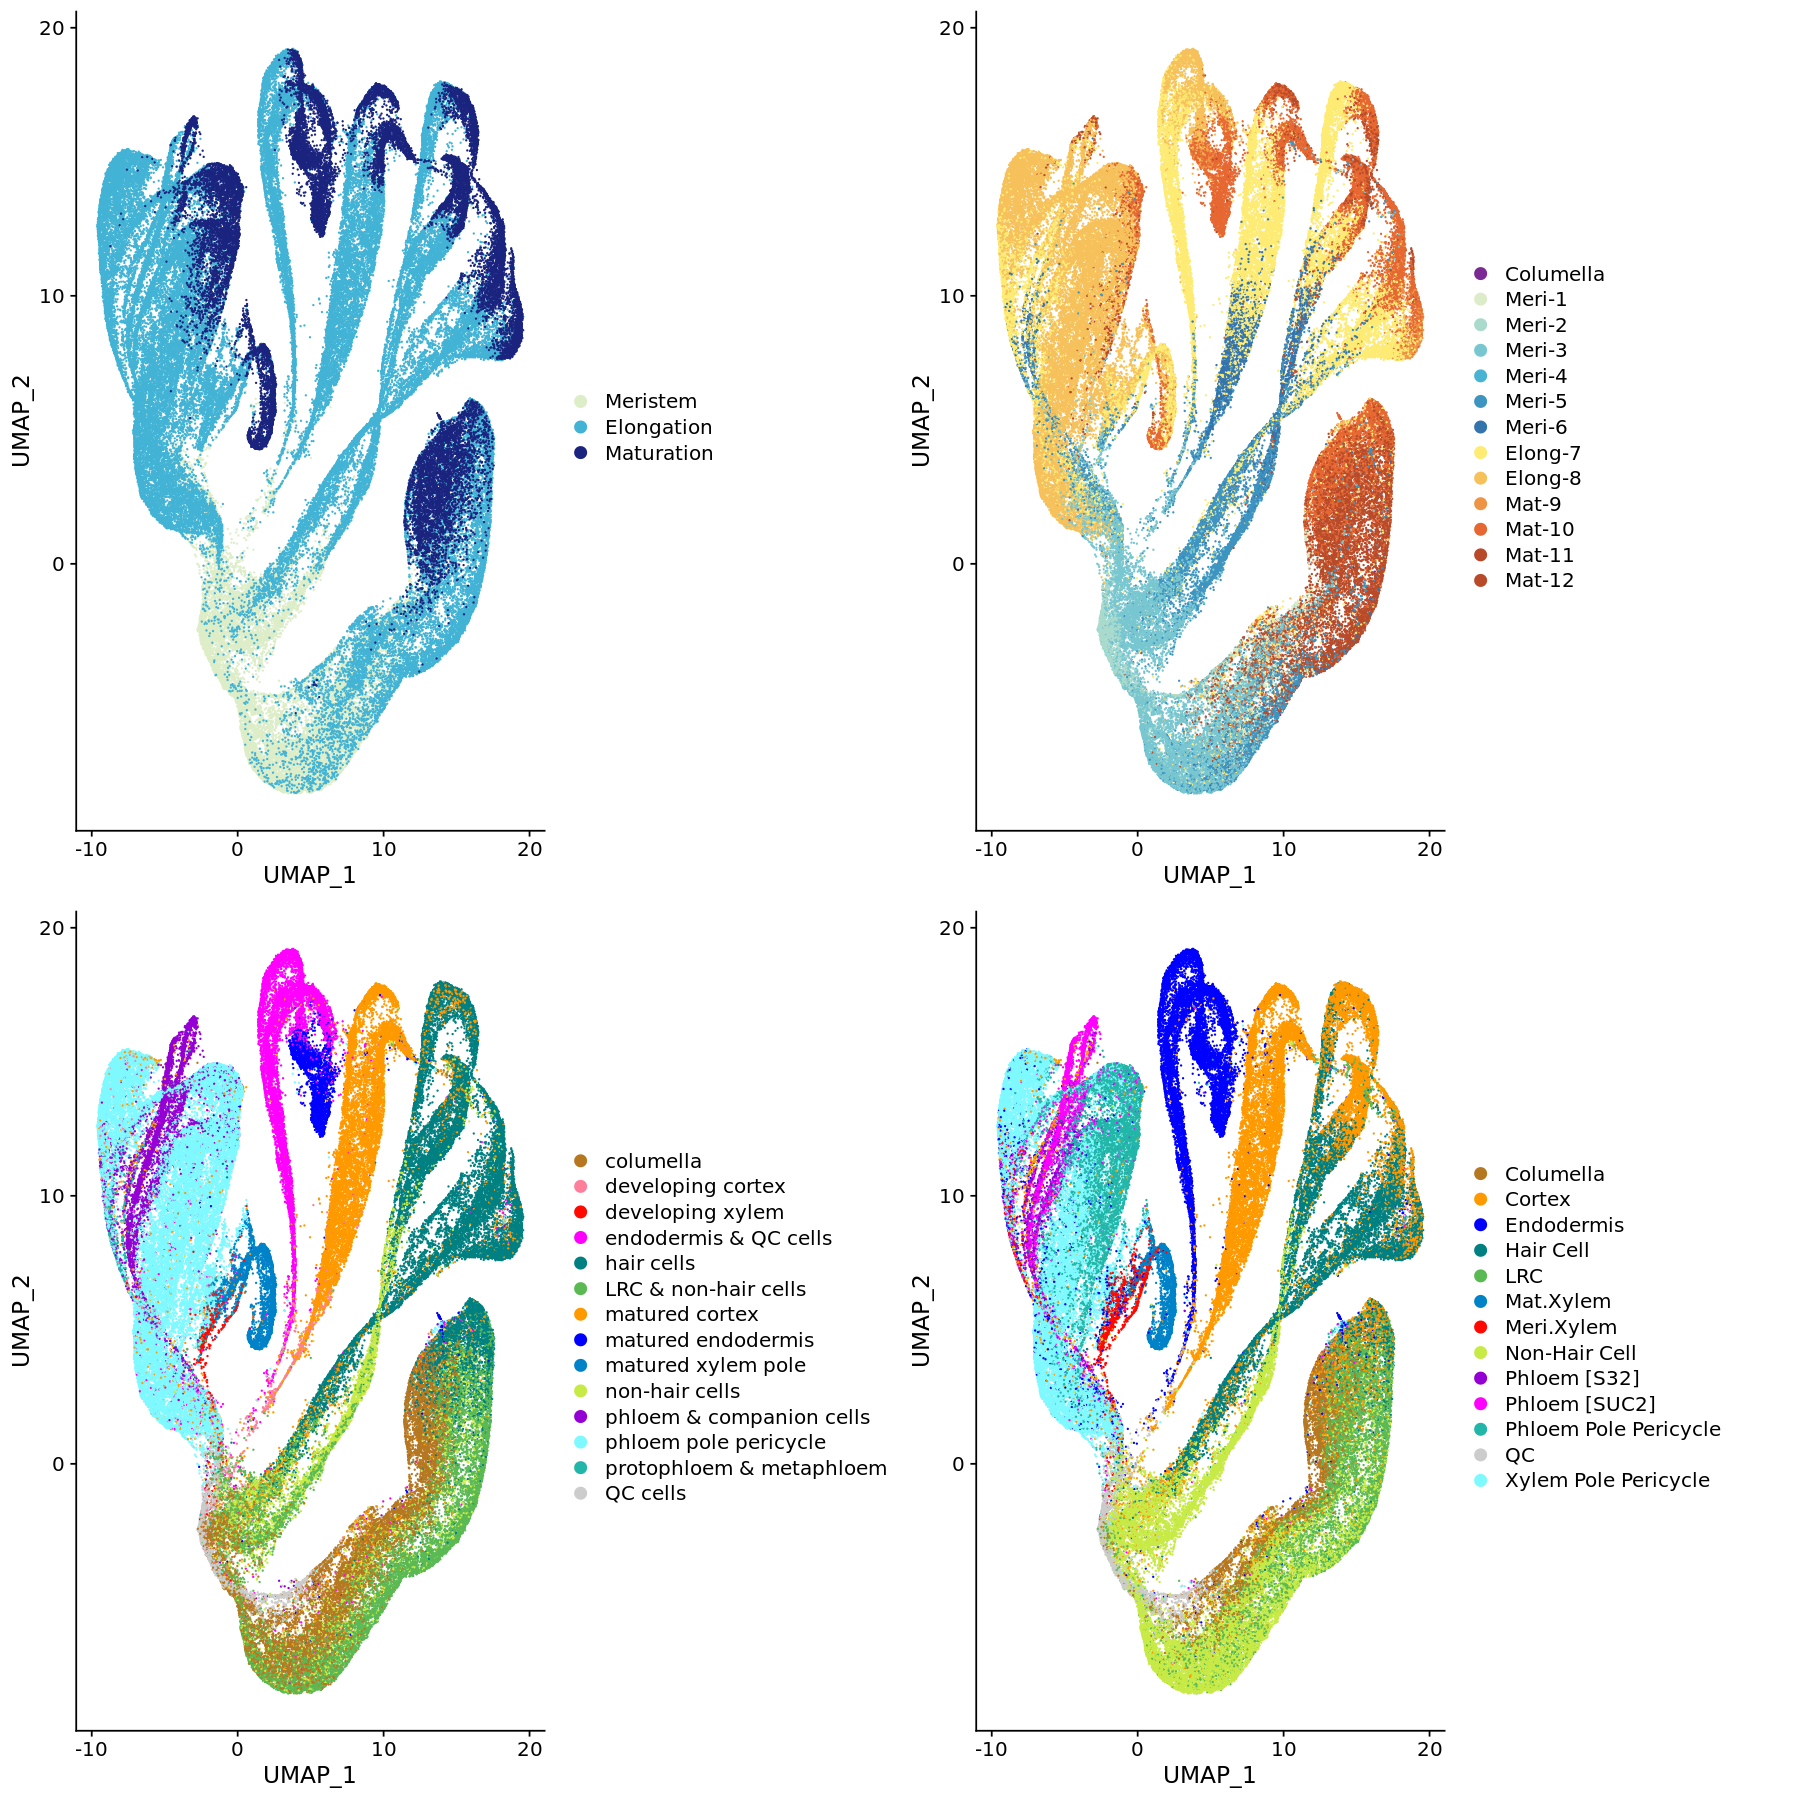

In [81]:
# Cell-level correlation-based annotation
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "timezone.ID.P", order = c("Maturation","Elongation","Meristem"),cols = c("#DCEDC8", "#42B3D5", "#1A237E"))
rc.integrated@meta.data$Long.ID.P <- factor(rc.integrated@meta.data$Long.ID.P, levels = longorder[sort(match(unique(rc.integrated$Long.ID.P),longorder))])  
color.long <- longpalette[sort(match(unique(rc.integrated$Long.ID.P),longorder))]
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "Long.ID.P", cols=color.long)
color <- celltypepalette[sort(match(unique(rc.integrated$celltype.ID.P),celltypeorder))]
p3 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.ID.P", cols = color)
color.rad <- radpalette[sort(match(unique(rc.integrated$Rad.ID.P),radorder))]
p4 <- DimPlot(rc.integrated, reduction = "umap", group.by = "Rad.ID.P", cols = color.rad)
options(repr.plot.width=15, repr.plot.height=15)
gl <- lapply(list(p1, p2, p3, p4), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)

## 6. Output 3D UMAP

In [84]:
# Set Seurat object name
int.name <- "16WT_110K"

In [85]:
# Make sure that the color match to the label it is supposed to color 
umap_1 <- rc.integrated[["umap"]]@cell.embeddings[,1]
umap_2 <- rc.integrated[["umap"]]@cell.embeddings[,2]
umap_3 <- rc.integrated[["umap"]]@cell.embeddings[,3]
timeorder <- c("Meristem","Elongation","Maturation")
timepalette <- c("#DCEDC8", "#42B3D5", "#1A237E")
rc.integrated@meta.data$timezone.ID.P <- factor(rc.integrated@meta.data$timezone.ID.P, levels = timeorder[sort(match(unique(rc.integrated$timezone.ID.P),timeorder))])
rc.integrated@meta.data$seucluster.timezone.ID.P <- factor(rc.integrated@meta.data$seucluster.timezone.ID.P, levels = timeorder[sort(match(unique(rc.integrated$seucluster.timezone.ID.P),timeorder))])
rc.integrated@meta.data$Long.ID.P <- factor(rc.integrated@meta.data$Long.ID.P, levels = longorder[sort(match(unique(rc.integrated$Long.ID.P),longorder))]) 
rc.integrated@meta.data$seucluster.Long.ID.P <- factor(rc.integrated@meta.data$seucluster.Long.ID.P, levels = longorder[sort(match(unique(rc.integrated$seucluster.Long.ID.P),longorder))]) 
doubletorder <- c("Singlet","Doublet")
doubletpalette <- c("#cccccc", "#ff4040")

# Prepare data for plotting
rc.integrated@meta.data$DF.classifications <- factor(rc.integrated@meta.data$DF.classifications, levels = doubletorder[sort(match(unique(rc.integrated$DF.classifications),doubletorder))])
plot.data <- FetchData(object = rc.integrated, vars = c("UMAP_1", "UMAP_2", "UMAP_3", "seurat_clusters", "celltype.ID.P", "timezone.ID.P", "Long.ID.P", "Rad.ID.P", "orig.ident", "DF.classifications",
                                                       "seucluster.celltype.ID.P","seucluster.timezone.ID.P","seucluster.Long.ID.P","seucluster.Rad.ID.P"))

# Make a column of row name identities (these will be your cell/barcode names)
plot.data$label <- paste(plot.data$orig.ident)

# Create vector with levels of object@ident
identities <- levels(rc.integrated@meta.data$seurat_clusters)

# Create vector of default ggplot2 colors
my_color_palette <- hue_pal()(length(identities))
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~seurat_clusters, 
        colors = my_color_palette,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_seurat_clusters.html"))

color <- celltypepalette[sort(match(unique(rc.integrated$celltype.ID.P),celltypeorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~celltype.ID.P, 
        colors = color,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_celltype.ID.P.html"))

color.time <- timepalette[sort(match(unique(rc.integrated$timezone.ID.P),timeorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~timezone.ID.P, 
        colors = color.time,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_timezone.ID.P.html"))

color.rad <- radpalette[sort(match(unique(rc.integrated$Rad.ID.P),radorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~Rad.ID.P, 
        colors = color.rad,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_Rad.ID.P.html"))

rc.integrated@meta.data$Long.ID.P <- factor(rc.integrated@meta.data$Long.ID.P, levels = longorder[sort(match(unique(rc.integrated$Long.ID.P),longorder))])   
color.long <- longpalette[sort(match(unique(rc.integrated$Long.ID.P),longorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~Long.ID.P, 
        colors = color.long,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_Long.ID.P.html"))

p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~orig.ident, 
        colors = rainbow(26),
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_orig.ident.html"))

color.doublet <- doubletpalette[sort(match(unique(rc.integrated$DF.classifications),doubletorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~DF.classifications, 
        colors = color.doublet,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_doublet.html"))

color <- celltypepalette[sort(match(unique(rc.integrated$seucluster.celltype.ID.P),celltypeorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~seucluster.celltype.ID.P, 
        colors = color,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_seucluster.celltype.ID.P.html"))

color.time <- timepalette[sort(match(unique(rc.integrated$seucluster.timezone.ID.P),timeorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~seucluster.timezone.ID.P, 
        colors = color.time,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_seucluster.timezone.ID.P.html"))

color.rad <- radpalette[sort(match(unique(rc.integrated$seucluster.Rad.ID.P),radorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~seucluster.Rad.ID.P, 
        colors = color.rad,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_seucluster.Rad.ID.P.html"))

color.long <- longpalette[sort(match(unique(rc.integrated$seucluster.Long.ID.P),longorder))]
p <- plot_ly(data = plot.data, 
        x = ~UMAP_1, y = ~UMAP_2, z = ~UMAP_3, 
        color = ~seucluster.Long.ID.P, 
        colors = color.long,
        type = "scatter3d", 
        mode = "markers", 
        marker = list(size = 3, width=2), # controls size of points
        text=~label, #This is that extra column we made earlier for which we will use for cell ID
        hoverinfo="text") #When you visualize your plotly object, hovering your mouse pointer over a point shows cell names
htmlwidgets::saveWidget(p, paste0(int.name,"_seucluster.Long.ID.P.html"))

Warning message in `[[.DimReduc`(object[[x]], cells, vars.use, drop = FALSE):
“The following embeddings are not present: UMAP_3”


## 7. Save Seurat integrated object

In [36]:
rc.integrated@reductions$umap_3D <- rc.integrated@reductions$umap
rc.integrated@reductions$umap <- rc.integrated@reductions$umap_2D

In [87]:
saveRDS(rc.integrated, file = "./Root_Atlas.rds")